In [1]:
import numpy as np
import pandas as pd
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import inferno, viridis
import matplotlib.pyplot as plt
import random
from typing import Sequence
from typing import Callable
import functools
import multiprocessing
import dask

import math
from dataclasses import dataclass

In [2]:
ds.transfer_functions.Image.border = 0

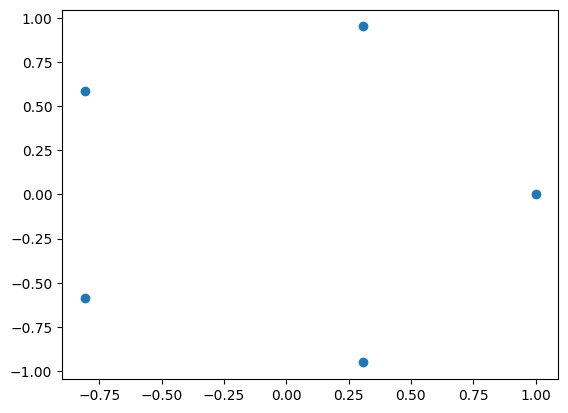

In [3]:
def roots_of_unity(n: int) -> np.ndarray:
    pol = np.zeros((n + 1,))
    pol[0] = 1
    pol[-1] = -1
    complex_roots = np.roots(pol)
    result = np.vstack((np.real(complex_roots), np.imag(complex_roots))).T
    result = np.round(result, 10)
    return result


plt.scatter(*zip(*roots_of_unity(5)))

In [4]:
def rand_int(n: int, current_point: int | None = None) -> int:
    if current_point is None:
        return random.randint(0, n)
    while True:
        candidate = random.randint(0, n)
        if current_point != candidate:
            return candidate


rand_int(4)
rand_int(4, 1)

4

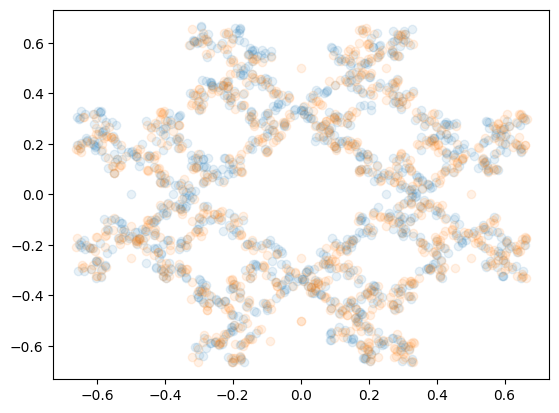

In [5]:
def simple_chaos(points: np.ndarray, n_iter: int, factor: float) -> np.ndarray:
    n_points = points.shape[0] -1
    chosen_point = rand_int(n_points)
    current_point = np.array([0, 0])
    return [
        current_point := (
            current_point - points[(chosen_point := rand_int(n_points, chosen_point))]
        )
        / factor
        for _ in range(n_iter)
    ]

def multiproc_chaos(points: np.ndarray, n_iter: int, factor: float) -> np.ndarray:
    n_workers = 4
    iter_per_worker = n_iter // n_workers
    with multiprocessing.Pool(n_workers) as pool:
        results = pool.starmap(simple_chaos, [(points, iter_per_worker, factor) for _ in range(n_workers)])
    return np.concatenate(results)

# def dask_chaos(points: np.ndarray, n_iter: int, factor: float) -> np.ndarray:
#     n_workers = 8
#     iter_per_worker = n_iter // n_workers
#     return dask.array.fromfunction(simple_chaos, shape=(5, 5), chunks=(2, 2), dtype="f8", **dict(points=points, n_iter=iter_per_worker, factor=factor))


plt.scatter(*zip(*simple_chaos(roots_of_unity(4), 1000, 2)), alpha=0.1)
plt.scatter(*zip(*multiproc_chaos(roots_of_unity(4), 1000, 2)), alpha=0.1)

In [6]:
from functools import cached_property


@dataclass(repr=True)
class ChaosGame:
    n_points: int
    n_iter: int
    approach_factor: float = 2
    points_factory: Callable[[int], np.ndarray] = roots_of_unity
    chaos_func: Callable[[np.ndarray, int, float], np.ndarray] = multiproc_chaos

    @cached_property
    def points(self) -> np.ndarray:
        return self.points_factory(self.n_points)

    @cached_property
    def chaos_values(self) -> pd.DataFrame:
        return pd.DataFrame(self.chaos_func(self.points, self.n_iter, self.approach_factor), columns=["x", "y"])

    def shader(self):
        df = pd.DataFrame(self.chaos_values, columns=["x", "y"])
        cvs = ds.Canvas(plot_width=700, plot_height=700)
        agg = cvs.points(df, "x", "y")
        return tf.shade(agg, cmap=viridis, how="cbrt")

    def __str__(self) -> str:
        points_str = "_".join(f"x{x:.2f}y{y:.2f}" for x,y in self.points)
        return f"chaos_{points_str}_f{self.approach_factor}_{self.chaos_func.__name__}"

    def _repr_html_(self):
        return self.shader()._repr_html_()


c = ChaosGame(3, 100, 2)
print(c, repr(c))

chaos_x-0.50y0.87_x-0.50y-0.87_x1.00y0.00_f2_multiproc_chaos ChaosGame(n_points=3, n_iter=100, approach_factor=2, points_factory=<function roots_of_unity at 0x7f15c5a42f80>, chaos_func=<function multiproc_chaos at 0x7f15c59c1d80>)


CPU times: user 60 µs, sys: 5 µs, total: 65 µs
Wall time: 98.7 µs


ChaosGame(n_points=6, n_iter=1000000, approach_factor=3, points_factory=<function roots_of_unity at 0x7f15c5a42f80>, chaos_func=<function multiproc_chaos at 0x7f15c59c1d80>)
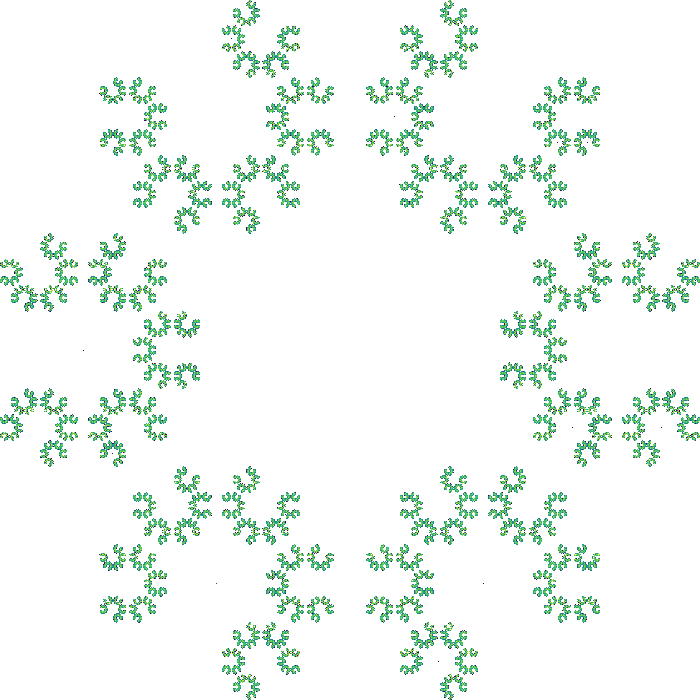

In [7]:
%%time
ChaosGame(6, 1_000_000, 3)

CPU times: user 44 µs, sys: 0 ns, total: 44 µs
Wall time: 73.2 µs


ChaosGame(n_points=6, n_iter=1000000, approach_factor=2.5, points_factory=<function roots_of_unity at 0x7f15c5a42f80>, chaos_func=<function multiproc_chaos at 0x7f15c59c1d80>)
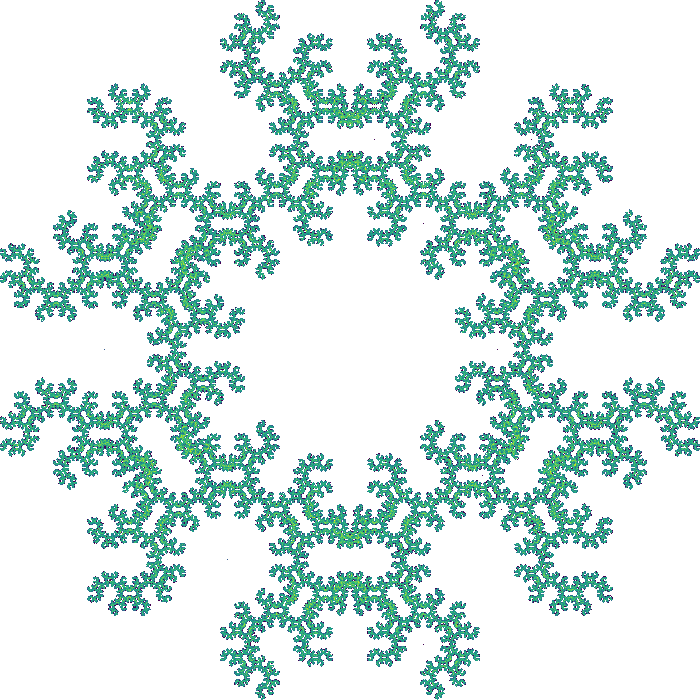

In [8]:
%%time
ChaosGame(6, 1_000_000, 2.5)

CPU times: user 27 µs, sys: 2 µs, total: 29 µs
Wall time: 43.2 µs


ChaosGame(n_points=6, n_iter=1000000, approach_factor=2.5, points_factory=<function roots_of_unity at 0x7f15c5a42f80>, chaos_func=<function simple_chaos at 0x7f15c5a42ef0>)
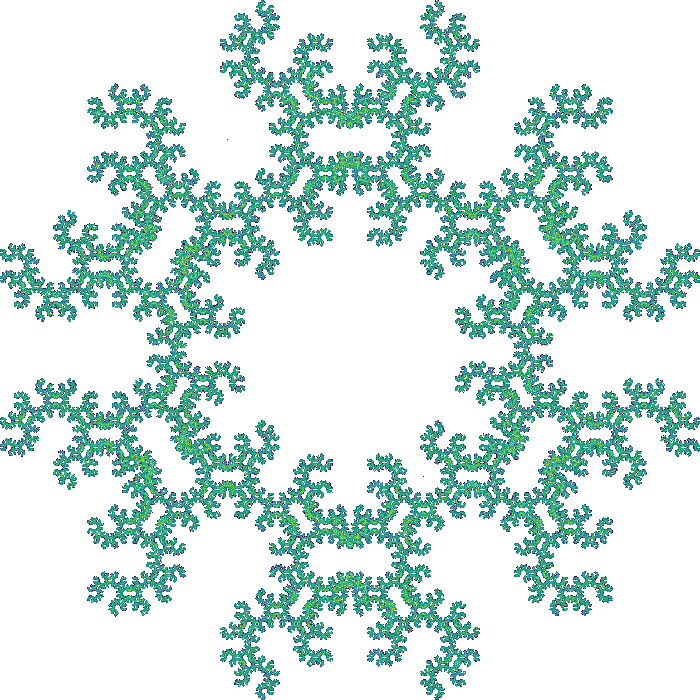

In [9]:
%%time
ChaosGame(6, 1_000_000, 2.5, chaos_func=simple_chaos)

ChaosGame(n_points=6, n_iter=5000000, approach_factor=1.75, points_factory=<function roots_of_unity at 0x7f15c5a42f80>, chaos_func=<function multiproc_chaos at 0x7f15c59c1d80>)
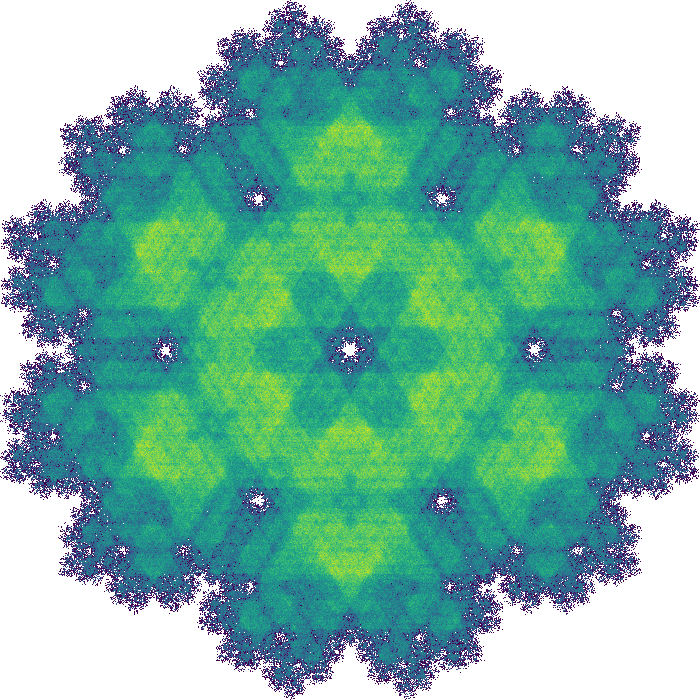

In [10]:
ChaosGame(6, 5_000_000, 7/4)

ChaosGame(n_points=5, n_iter=5000000, approach_factor=2, points_factory=<function roots_of_unity at 0x7f15c5a42f80>, chaos_func=<function multiproc_chaos at 0x7f15c59c1d80>)
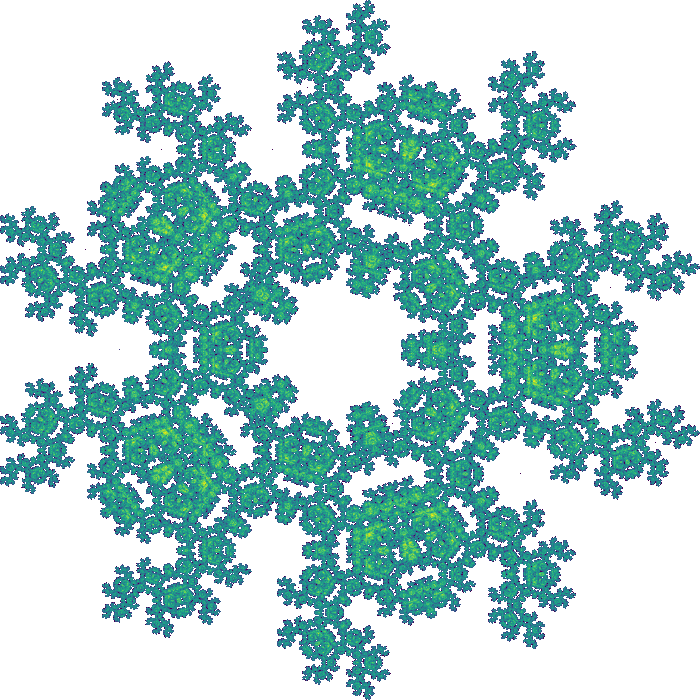

In [11]:
ChaosGame(5, 5_000_000)

ChaosGame(n_points=4, n_iter=1000000, approach_factor=2, points_factory=<function roots_of_unity at 0x7f15c5a42f80>, chaos_func=<function multiproc_chaos at 0x7f15c59c1d80>)
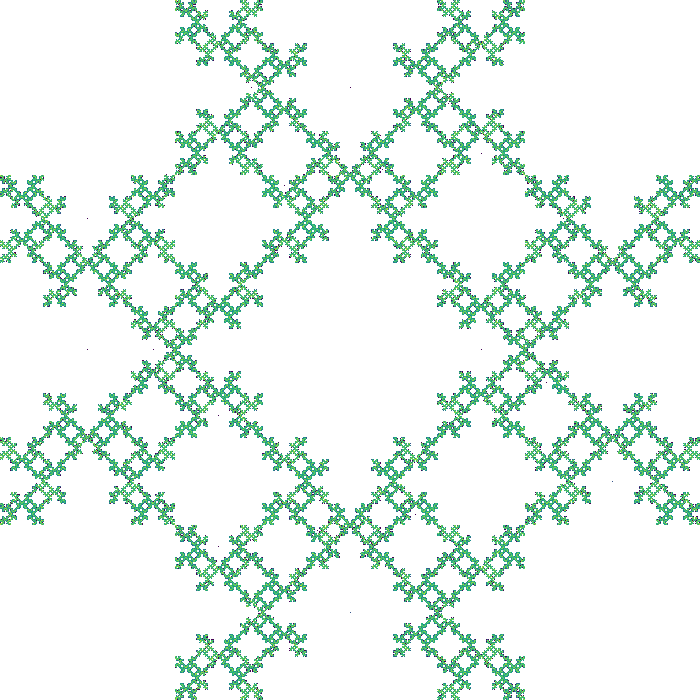

In [12]:
ChaosGame(4, 1_000_000)

ChaosGame(n_points=3, n_iter=1000000, approach_factor=1.5, points_factory=<function roots_of_unity at 0x7f15c5a42f80>, chaos_func=<function multiproc_chaos at 0x7f15c59c1d80>)
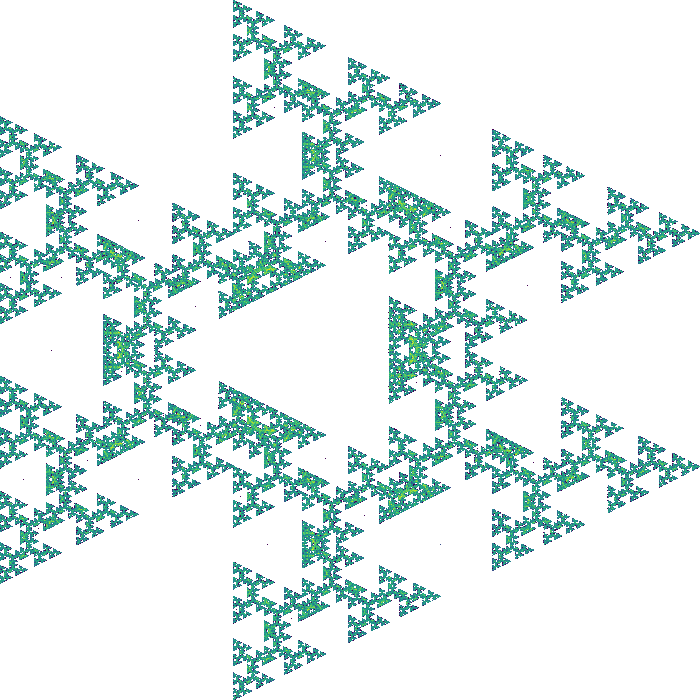

In [13]:
ChaosGame(3, 1_000_000, 3/2)

In [14]:
ChaosGame(3, 10_000_000, 10/8)

In [ ]:
%%time
ChaosGame(6, 5_000_000, 2)